## Analyzing Weather Data from OpenWeatherMap APIime.
Tasks to Perform:
1. Register and obtain API key from OpenWeatherMap.
2. Interact with the OpenWeatherMap API using the API key to retrieve weather data fora specific location.
3. Extract relevant weather attributes such as temperature, humidity, wind speed, andprecipitation from the
API response.
4. Clean and preprocess the retrieved data, handling missing values or inconsistentformats.
5. Perform data modeling to analyze weather patterns, such as calculating average temperature,
maximum/minimum values, or trends over time.
6. Visualize the weather data using appropriate plots, such as line charts, bar plots, orscatter plots, to
represent temperature changes, precipitation levels, or wind speed variations.
7. Apply data aggregation techniques to summarize weather statistics by specific timeperiods (e.g., daily,
monthly, seasonal).
8. Incorporate geographical information, if available, to create maps or geospatialvisualizations representing
weather patterns across different locations.
9. Explore and visualize relationships between weather attributes, such as temperatureand humidity, using
correlation plots or heatmaps.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import geopandas as gpd
import folium

! pip install geopandas
! pip install folium

In [111]:
api_key = 'f06082d2638893ea5ba2bc425b43644f'
lat = 18.184135
lon = 74.610764   #Pune Location Co-ordinate
# Construct the API URL for the forecast
api_url=f"https://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={api_key}"
# Send a GET request to the API
response = requests.get(api_url)
weather_data = response.json()

In [112]:
# Extract relevant weather attributes using list comprehension
timestamps = [pd.to_datetime(item['dt'], unit='s') for item in weather_data['list']]
temperatures = [item['main']['temp'] for item in weather_data['list']]
humidity = [item['main']['humidity'] for item in weather_data['list']]
wind_speed = [item['wind']['speed'] for item in weather_data['list']]
weather_description = [item['weather'][0]['description'] for item in weather_data['list']]

In [113]:
# Create a pandas DataFrame with the extracted weather data
weather_df = pd.DataFrame({
    'Timestamp': timestamps,
    'Temperature': temperatures,
    'Humidity': humidity,
    'Wind Speed': wind_speed,
    'Weather Description': weather_description,
})

In [114]:
# Set the Timestamp column as the DataFrame's index
weather_df.set_index('Timestamp', inplace=True)

In [115]:
weather_df.isnull().sum()

Temperature            0
Humidity               0
Wind Speed             0
Weather Description    0
dtype: int64

In [116]:
# Clean and preprocess the data
weather_df.fillna(0, inplace=True)

In [117]:
# Convert kelvin to Celsius
weather_df['Temperature'] = weather_df['Temperature'].apply(lambda x: x - 273.15) 
print(weather_df)

                     Temperature  Humidity  Wind Speed Weather Description
Timestamp                                                                 
2024-11-04 09:00:00        30.05        34        3.05          few clouds
2024-11-04 12:00:00        29.61        35        2.49    scattered clouds
2024-11-04 15:00:00        25.98        42        4.00       broken clouds
2024-11-04 18:00:00        23.89        50        2.97       broken clouds
2024-11-04 21:00:00        22.63        53        3.37           clear sky
2024-11-05 00:00:00        20.86        60        1.23           clear sky
2024-11-05 03:00:00        24.56        49        2.60           clear sky
2024-11-05 06:00:00        29.44        37        3.73           clear sky
2024-11-05 09:00:00        31.38        28        3.81           clear sky
2024-11-05 12:00:00        29.64        34        2.03           clear sky
2024-11-05 15:00:00        26.01        39        3.03           clear sky
2024-11-05 18:00:00      

In [118]:
# Plotting
# Daily mean calculations
daily_mean_temp = weather_df['Temperature'].resample('D').mean()
daily_mean_humidity = weather_df['Humidity'].resample('D').mean()
daily_mean_wind_speed = weather_df['Wind Speed'].resample('D').mean()

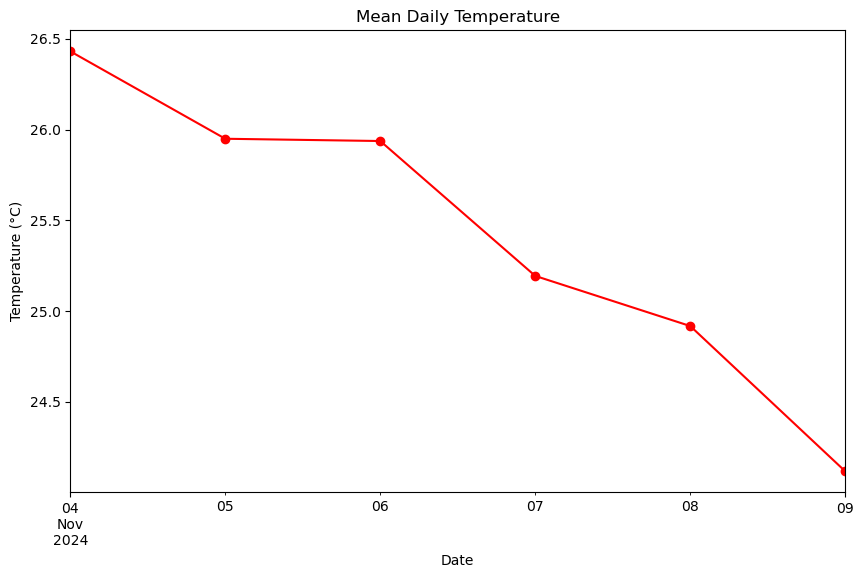

In [123]:
# Plot the mean daily temperature (Line plot)
plt.figure(figsize=(10, 6))
daily_mean_temp.plot(color='red', marker='o')
plt.title('Mean Daily Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

TypeError: 'bool' object is not callable

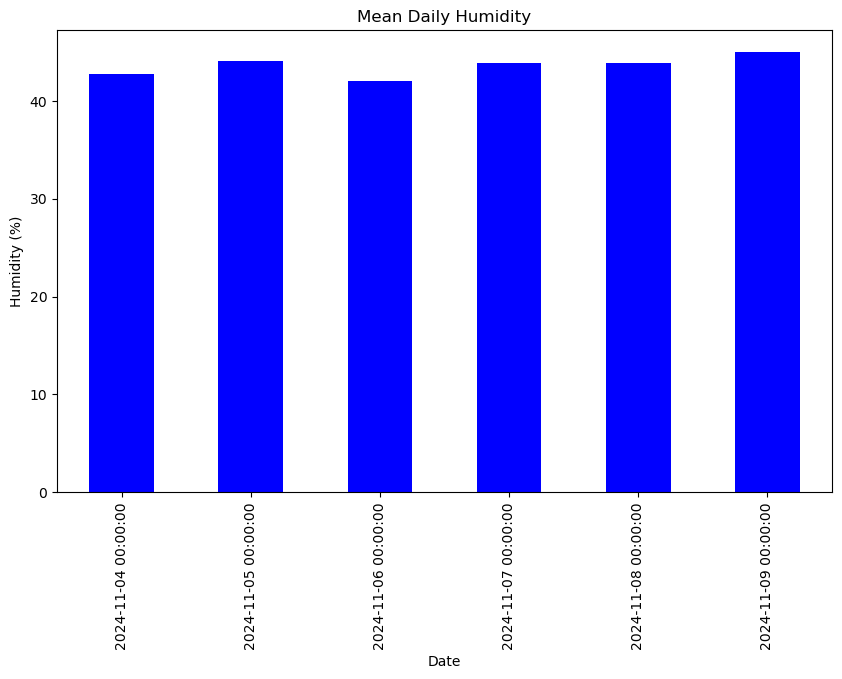

In [124]:
# Plot the mean daily humidity (Bar plot)
plt.figure(figsize=(10, 6))
daily_mean_humidity.plot(kind='bar', color='blue')
plt.title('Mean Daily Humidity')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.grid(True)
plt.show()

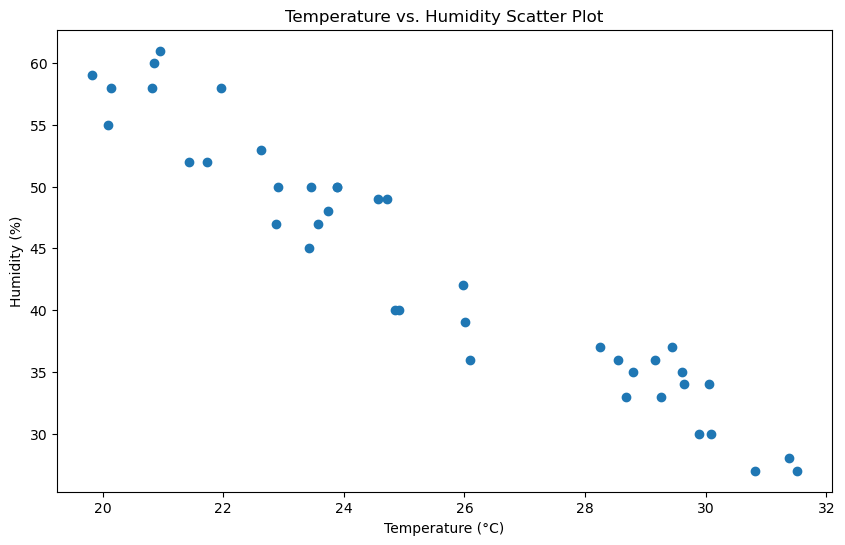

In [120]:
# Scatter plot of Temperature vs. Humidity
plt.figure(figsize=(10, 6))
plt.scatter(weather_df['Temperature'], weather_df['Humidity'])
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.title('Temperature vs. Humidity Scatter Plot')
plt.show()

TypeError: 'bool' object is not callable

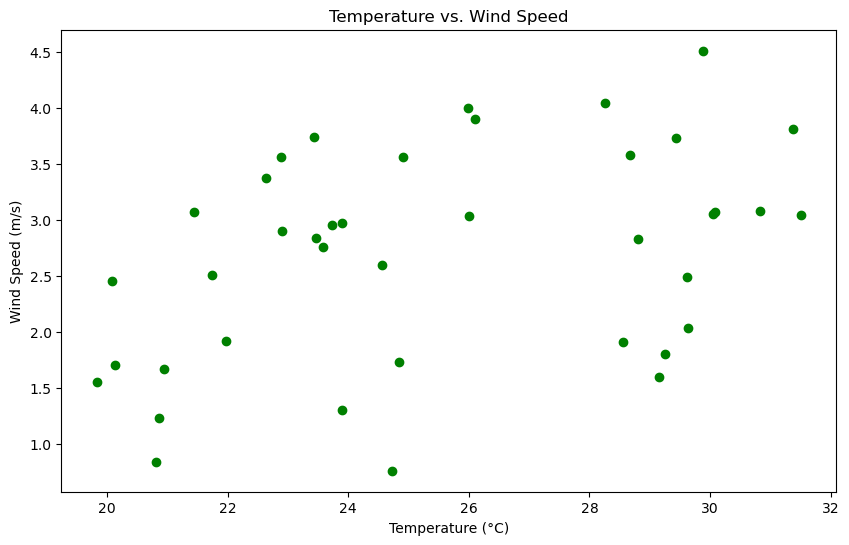

In [121]:
# Plot temperature vs. wind speed (Scatter plot)
plt.figure(figsize=(10, 6))
plt.scatter(weather_df['Temperature'], weather_df['Wind Speed'], color='green')
plt.title('Temperature vs. Wind Speed')
plt.xlabel('Temperature (°C)')
plt.ylabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()

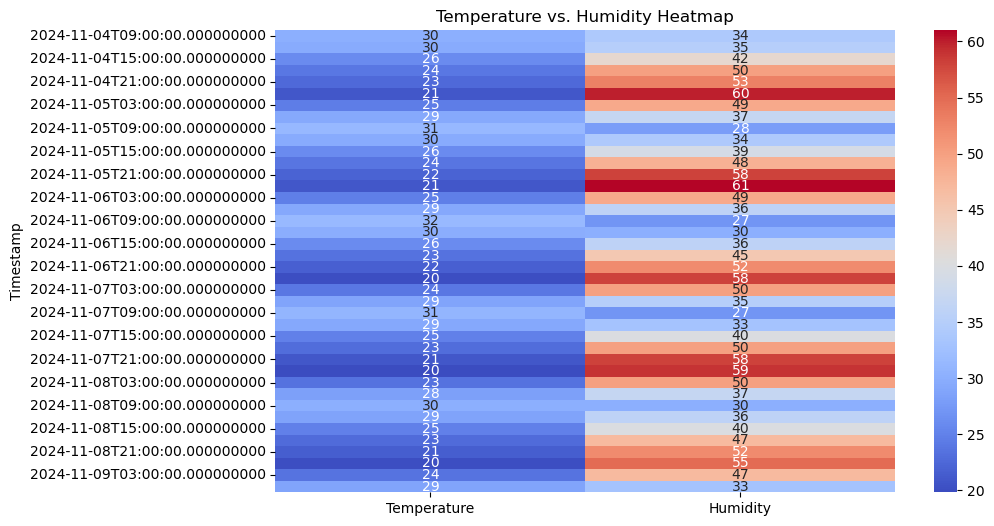

In [125]:
# Heatmap of Temperature vs. Humidity
heatmap_data = weather_df[['Temperature', 'Humidity']]
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Temperature vs. Humidity Heatmap')
plt.show()

In [ ]:
# Load a world map shapefile using geopandas
#world_map = gpd.read_file('/content/ne_110m_admin_0_countries.shp')
#world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))  From Manual
world_map = gpd.read_file('ne_110m_admin_0_countries.shp')   #https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
# Rename the column used for merging in the world map DataFrame
world_map.rename(columns={'geometry': 'Weather Description'}, inplace=True)

# Merge the weather data with the world map based on location
# Changed 'location' to 'Location' to match the column name in weather_df
weather_map = world_map.merge(weather_df, on='Weather Description')

# Create a folium map centered around the mean latitude and longitude of all locations
map_center = [weather_df['Latitude'].mean(), weather_df['Longitude'].mean()]
weather_map_folium = folium.Map(location=map_center, zoom_start=2)

# Add weather markers to the folium map
for index, row in weather_map.iterrows():
    location = [row['Latitude'], row['Longitude']]
    temperature = row['Temperature']
    marker_text = f'Temperature: {temperature} K'
    folium.Marker(location, popup=marker_text, icon=folium.Icon(icon='cloud', color='red')).add_to(weather_map_folium)

# Display the folium map
weather_map_folium

In [130]:
# Extract relevant weather attributes 
temperature = [item['main']['temp'] for item in weather_data['list']]
humidity =[item['main']['humidity'] for item in weather_data['list']]
wind_speed = [item['wind']['speed'] for item in weather_data['list']]
latitude = weather_data['coord']['lat'] 
longitude = weather_data['coord']['lon']
# Create a DataFrame for the location's weather data
location_df = pd.DataFrame({
    'Location': [location], 
    'Temperature': [temperature],
    'Humidity': [humidity], 
    'Wind Speed': [wind_speed],
    'Latitude': [latitude], 
    'Longitude': [longitude]
})
# Append the location's weather data to the main DataFrame 
weather_df = weather_df.append(location_df, ignore_index=True)
weather_df

KeyError: 'coord'

In [110]:
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
# Rename the column used for merging in the world map DataFrame
world_map.rename(columns={'name': 'Location'}, inplace=True)
# Merge the weather data with the world map based on location
weather_map =world_map.merge(weather_df, on='Location')
# Create a folium map centered around the mean latitude and longitude of all locations
map_center =[weather_df['Latitude'].mean(), weather_df['Longitude'].mean()] 
weather_map_folium =folium.Map(location=map_center, zoom_start=2)
# Add weather markers to the folium mapfor index, row in weather_map.iterrows():
location = [row['Latitude'], row['Longitude']]temperature = row['Temperature']
marker_text = f'Temperature: {temperature} K'
folium.Marker(location, popup=marker_text, icon=folium.Icon(icon='cloud',
color='red')).add_to(weather_map_folium)
# display the folium mapweather_map_folium
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

SyntaxError: invalid syntax (3042164010.py, line 10)